# Cart Pole Balancing

### Problem Statement

The cart and pole problem consists of a cart that can move left and right along a frictionless track. The cart has a pole attached to the top of it, which starts out in a vertical upright position, however, by design, the pole will fall either to the left or right when not balanced. 
<img src="cartpole.png" alt="CartPole" style="width: 400px;"/>

The goal here is to prevent this pole from falling over. A reward of +1 will be given for each time step that the pole remains upright, and an episode will deemed over when the pole is more than 15 degrees from vertical or when the cart moves more than 2.4 units from the center of the screen. 

So, the longer the pole remains upright without deviating too far from the center of the screen, the more reward our agent will get.

### Solution Approach
Objective in this problem is to build and train a deep Q-network to learn to balance a pole on a moving cart. 

#### DQN Algorithm
1. Initialize *replay memory* capacity.<br>
2. Initialize the *policy network* with random weights.<br>
3. Clone the policy network, and call it the *target network*.<br>
4. For each episode:<br>
&emsp;1. Initialize the starting state.<br>
&emsp;2.For each time step:<br>
&emsp;&emsp;1. Select an action.<br>
&emsp;&emsp;&emsp; - Via exploration or exploitation<br>
&emsp;&emsp;2. Execute selected action in an emulator.<br>
&emsp;&emsp;3. Observe reward and next state.<br>
&emsp;&emsp;4. Store experience in replay memory.<br>
&emsp;&emsp;5. Sample random batch from replay memory.<br>
&emsp;&emsp;6. Preprocess states from batch.<br>
&emsp;&emsp;7. Pass batch of preprocessed states to policy network.<br>
&emsp;&emsp;8. Calculate loss between output $Q$-values and target $Q$-values.<br>
&emsp;&emsp;&emsp; - Requires a pass to the target network for the next state<br>
&emsp;&emsp;9. Gradient descent updates weights in the policy network to minimize loss.<br>
&emsp;&emsp;&emsp; - After $x$ time steps, weights in the target network are updated to the weights in the policy network.

#### Import Relevant Components

In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T    

# Setup Display
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

#### Deep Q-Network
Build a simple neural network consisting of two fully connected hidden layers and an output layer.

In [2]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
            
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2) # since 2 possible actions: move left or right
        
    # forward pass to the network
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

#### Experiences
Experience class creates experiences that are used to train our DQN.

In [3]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

#### Replay Memory
Experiences are stored in and sampled from replay memory having some set capacity.

In [4]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

#### Epsilon Greedy Strategy
This strategy is used to balance exploration-exploitation dilemma. 
Define epsilon, an exploration rate, initially set to 1. Thus agent starts out by just exploring the environment by taking a random action from a given state. As the agent learns more about the environment, epsilon will decay by some decay rate so that agent explores less and exploits more of what it has learned about environment.

In [5]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

#### Reinforcement Learning Agent
The agent selects an action based on epsilon-greedy strategy.

In [6]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

#### Environment Manager
This manages the cart and pole environment.

In [7]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    # Wrapper Functions
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
    
    def render(self, mode='human'):
        return self.env.render(mode)
    
    # Number of actions available to agent
    def num_actions_available(self):
        return self.env.action_space.n
    
    # Take action in the environment
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    # Start an episode
    def just_starting(self):
        return self.current_screen is None
    
    # Get state of the environment: represent a single state as difference between current screen and previous screen
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    # Preprocess Screen/Image
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
    
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
    
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)

#### Example Screens
1. Non-processed screen: It is the initial image we get from the cart-pole environment.

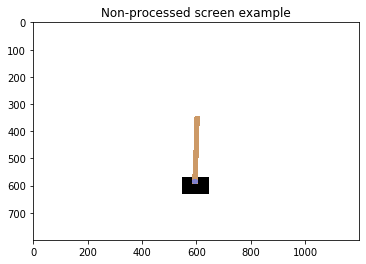

In [8]:
# Non-Processed Screen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

2. Processed Screen: It is the image obtained by doing preprocessing on the initial image, for ex, by cropping and scaling.

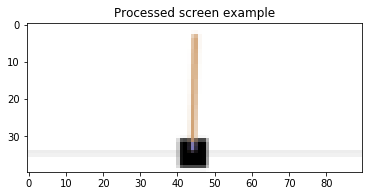

In [9]:
# Processed Screen
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

3. Starting state: A state is represented as the difference between two consecutive screens. When we are at the start of a new episode, there is no last screen to compare to the current screen. So, represent starting state with a fully black screen.

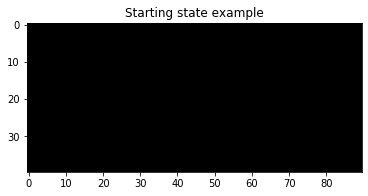

In [10]:
# Starting State
screen = em.get_state()
    
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

4. Non-starting state: Since we take difference between current and previous screen, most pixel values will become zero. The only ones that are non-zero tell us about the relative change in position of cart and pole.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


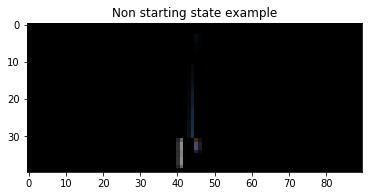

In [11]:
# Non-starting state
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

5. Ending state: Ending state is again a fully black screen.

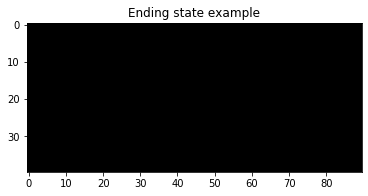

In [12]:
# Ending state
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

#### Calculate Q-Values
Calculate the q-values for the current states using the policy network, and the next states using the target network.

In [13]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
        .max(dim=1)[0].eq(0).type(torch.BoolTensor)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

#### Utility Functions

In [14]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
            moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
    
# Convert batch of Experiences to Experience of batches
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

### Main Program

#### Hyperparameters

In [15]:
batch_size = 256
discount = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

#### Essential Objects

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

#### Training
Training process implements the above described DQN algorithm.

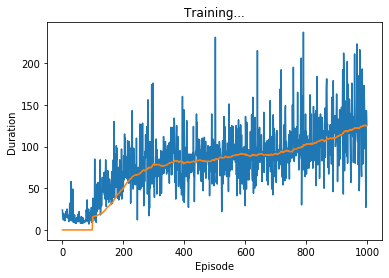

Episode 1000 
 100 episode moving avg: 125.0


In [17]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
    
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * discount) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

### Conclusion
1. For first 100 episodes, agent could not balance the pole. But by last 100 episodes, agent was able to balance the pole for 125 time steps.
2. Thus our agent did learn over time as 100 episode moving average is increasing with time.